# Principles & Concepts of Data Mining Algorithms — Mini Demo
**Covers:** supervised (Decision Tree, k-NN, GaussianNB), unsupervised (K-Means + PCA),  and association rules (Apriori toy).


In [1]:
# Cell 1 — Imports & global settings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from itertools import combinations
from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    silhouette_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

RNG = 42
np.random.seed(RNG)
plt.rcParams.update({"figure.figsize": (6,4), "axes.grid": True})


In [2]:
# Helpers

def evaluate_classifier(y_true, y_pred, model_name: str):
    """Print basic metrics + confusion matrix."""
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    print(f"\n {model_name} — metrics")
    print(f"Accuracy: {acc:.3f}")
    print(f"F1 (macro): {f1_macro:.3f}")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {model_name}")
    plt.tight_layout()
    plt.show()

def plot_pca_2d(X, y=None, title="PCA (2D)"):
    pca = PCA(n_components=2, random_state=RNG)
    X2 = pca.fit_transform(X)
    plt.figure()
    if y is None:
        plt.scatter(X2[:,0], X2[:,1], s=18)
    else:
        for cls in np.unique(y):
            idx = (y == cls)
            plt.scatter(X2[idx,0], X2[idx,1], s=18, label=str(cls))
        plt.legend(title="Class")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Elbow method
def plot_elbow_kmeans(X, kmin=2, kmax=10, title_prefix=""):
    inertias = []
    ks = list(range(kmin, kmax+1))
    for k in ks:
        km = KMeans(n_clusters=k, random_state=RNG, n_init=10)
        km.fit(X)
        inertias.append(km.inertia_)
    plt.figure()
    plt.plot(ks, inertias, marker="o")
    plt.xlabel("k"); plt.ylabel("SSE (inertia)")
    plt.title(f"{title_prefix} Elbow method")
    plt.tight_layout()
    plt.show()

In [3]:
USE_DATASET = "breast_cancer"  # or "iris"

if USE_DATASET == "breast_cancer":
    data = load_breast_cancer()
elif USE_DATASET == "iris":
    data = load_iris()
else:
    raise ValueError("Unknown dataset")

X, y = data.data, data.target

Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RNG
)


In [4]:

# Decision Tree
dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=4,          # small depth to reduce overfitting
    random_state=RNG
)

# Random Forest (non-linear ensemble of trees)
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=RNG
)

# Fit
dt.fit(Xtr, ytr)
rf.fit(Xtr, ytr)

# Predict
yhat_dt = dt.predict(Xte)
yhat_rf = rf.predict(Xte)

print(" Models trained and predictions computed.")

 Models trained and predictions computed.



Decision Tree (simple)

 Decision Tree (max_depth=4) — metrics
Accuracy: 0.939
F1 (macro): 0.934

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        42
           1       0.96      0.94      0.95        72

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114



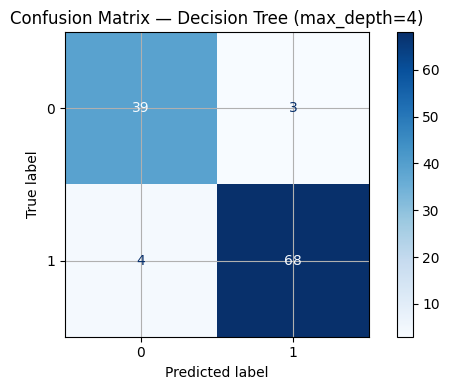

In [5]:
# Models (simple, no grid search)
print("\nDecision Tree (simple)")
dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=4,           # small depth to reduce overfitting
    random_state=RNG
)
dt.fit(Xtr, ytr)
yp_dt = dt.predict(Xte)
evaluate_classifier(yte, yp_dt, model_name="Decision Tree (max_depth=4)")



k-NN (scaled)

 k-NN (k=5, distance) — metrics
Accuracy: 0.956
F1 (macro): 0.953

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



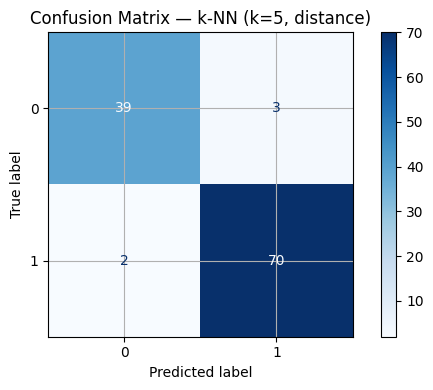

In [6]:
print("\nk-NN (scaled)")
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5, weights="distance"))
])
knn_pipe.fit(Xtr, ytr)
yp_knn = knn_pipe.predict(Xte)
evaluate_classifier(yte, yp_knn, model_name="k-NN (k=5, distance)")



Naive Bayes (GaussianNB)

 GaussianNB — metrics
Accuracy: 0.939
F1 (macro): 0.934

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        42
           1       0.95      0.96      0.95        72

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



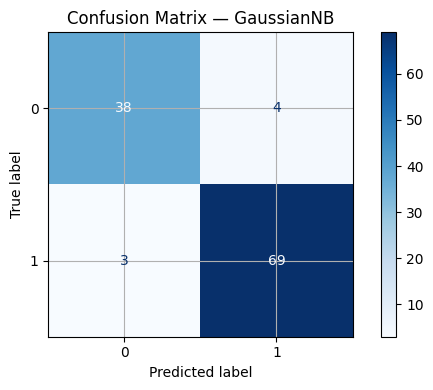

In [7]:
print("\nNaive Bayes (GaussianNB)")
gnb = GaussianNB()
gnb.fit(Xtr, ytr)
yp_nb = gnb.predict(Xte)
evaluate_classifier(yte, yp_nb, model_name="GaussianNB")




Elbow method for K-Means (optional)


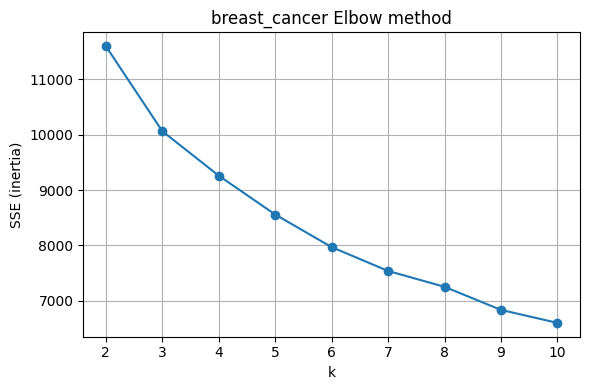

In [8]:
print("\nElbow method for K-Means (optional)")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
plot_elbow_kmeans(X_scaled, kmin=2, kmax=10, title_prefix=USE_DATASET)



K-Means (Clustering)
Silhouette score (k=2): 0.343


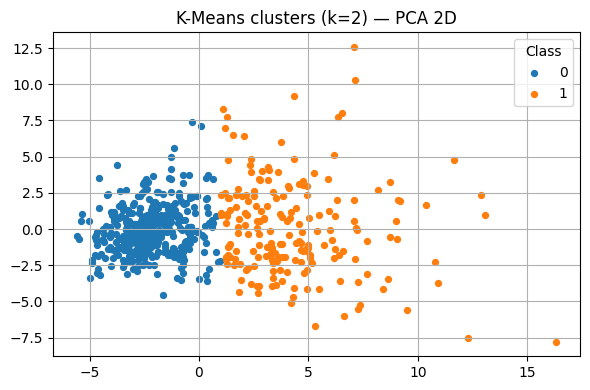

Contingency matrix (class vs cluster):
 [[ 36 176]
 [339  18]]


In [9]:
print("\nK-Means (Clustering)")
k = max(2, len(np.unique(y)))  # sensible default
km = KMeans(n_clusters=k, random_state=RNG, n_init=10)
labels_km = km.fit_predict(X_scaled)

if k >= 2 and len(np.unique(labels_km)) > 1:
    sil = silhouette_score(X_scaled, labels_km)
    print(f"Silhouette score (k={k}): {sil:.3f}")

plot_pca_2d(X_scaled, labels_km, title=f"K-Means clusters (k={k}) — PCA 2D")

# Optional: compare clusters vs classes
try:
    from sklearn.metrics.cluster import contingency_matrix
    cont = contingency_matrix(y, labels_km)
    print("Contingency matrix (class vs cluster):\n", cont)
except Exception as e:
    print("(Skipping contingency_matrix)", e)


In [10]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Toy transactions
transactions = [
    {"milk", "bread", "butter"},
    {"milk", "eggs"},
    {"bread", "butter"},
    {"milk", "bread", "eggs"},
    {"butter", "jam"},
    {"milk", "bread", "butter", "jam"},
]

# Encode to one-hot DataFrame (bool)
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_tx = pd.DataFrame(te_ary, columns=te.columns_)

# Frequent itemsets
freq = apriori(df_tx, min_support=0.30, use_colnames=True)

# Association rules
rules = association_rules(freq, metric="confidence", min_threshold=0.60)

# Displays
print("Frequent itemsets:")
display(freq.sort_values(["support","itemsets"], ascending=[False, True]).reset_index(drop=True))

print("\nRules (antecedents → consequents):")
display(
    rules.sort_values(["confidence","lift"], ascending=[False, False])[
        ["antecedents","consequents","support","confidence","lift"]
    ].reset_index(drop=True)
)


Frequent itemsets:


,support,itemsets
0,0.666667,(bread)
1,0.666667,(butter)
2,0.666667,(milk)
3,0.500000,"(bread, butter)"
4,0.500000,"(bread, milk)"
5,0.333333,(eggs)
6,0.333333,(jam)
7,0.333333,"(jam, butter)"
8,0.333333,"(milk, butter)"
9,0.333333,"(eggs, milk)"



Rules (antecedents → consequents):


,antecedents,consequents,support,confidence,lift
0,(jam),(butter),0.333333,1.000000,1.500
1,(eggs),(milk),0.333333,1.000000,1.500
2,"(milk, butter)",(bread),0.333333,1.000000,1.500
3,(bread),(butter),0.500000,0.750000,1.125
4,(butter),(bread),0.500000,0.750000,1.125
5,(bread),(milk),0.500000,0.750000,1.125
6,(milk),(bread),0.500000,0.750000,1.125
7,"(bread, milk)",(butter),0.333333,0.666667,1.000
8,"(bread, butter)",(milk),0.333333,0.666667,1.000


### Notes
- **Supervised:** Decision Tree (interpretable), k-NN with scaling (distance weights), GaussianNB baseline.
- **Unsupervised:** K-Means with PCA 2D visualization; 
                    optional Elbow shows how to pick *k*; 
                    Silhouette validates cohesion/separation.
- **Association:** Apriori on a small toy set; pure-Python fallback avoids extra installs.
- Keeps code minimal while covering the main **principles & concepts** for exam and portfolio.
